<a href="https://colab.research.google.com/github/entruv/code_stream/blob/master/chess/03_11_2020_Utiliser_Recherche_d'arbre_echecs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recapitulatif de l'avancement pour l'IA des echecs

Lien du precedent notebook:
https://github.com/entruv/code_stream/blob/master/chess/03-10-2020%20Small%20Model%20learn%20legal%20moves%20chess.ipynb

- [x] Avoir un modele qui peut predire des probabilites pour chaque coup, et estimer qui a l'avantage dans une position d'echecs
- [ ] simuler une partie d'echecs, cela va creer un Arbre ou les noeuds sont des positions d'echecs
- [ ] sauvegarder les resultats de cette simulation et entrainer le modele a predire qui avait l'avantage, sans faire de simulation

In [0]:
import chess

In [0]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import copy #permet de copier un objet proprement

class BoardAi(chess.Board):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    # def copy(self):
    #   return copy.copy(self)

    def find_legal_moves(self):
      return list(self.legal_moves)
  
    def find_children(self):
      "All possible successors of this board state"
      childrens = []
      for move in self.find_legal_moves():
          board = self.copy()
          board.push(move)
          childrens.append(board)
      return childrens

    def find_random_child(self):
      childrens = self.find_children()
      if childrens:
        print(f"exploring {len(childrens)} childrens from this position: {self.fen()}")
        return np.random.choice(childrens)
        "Random successor of this board state (for more efficient simulation)"
      return None

    def is_terminal(self):
        "Returns True if the node has no children"
        return len(self.find_children()) == 0


    def get_reward(self, result):
      if result == "1-0":
          return 1
      if result == "0-1":
          return -1
      if result == "1/2-1/2":
          return 0 #biais pour explorer les parties qui ne rendent pas un etat null
    def reward(self):
      "Assumes `self` is terminal node."
      result = self.result() #vient de la classe parent chess.Board()
      return self.get_reward(result)

    def identifier(self):
      return str(self.board_fen()) + str(self.turn) + str(self.castling_rights) + str(self.ep_square)
    
    def __hash__(self):
        "Nodes must be hashable"
        #permet de distinguer si deux noeuds sont identiques ou differents. Utile car mes noeuds sont des objets pythons difficile a comparer par nature
        return hash(self.identifier())
    
    def __eq__(node1, node2):
      return node1.identifier() == node2.identifier()

In [0]:
import numpy as np

In [0]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


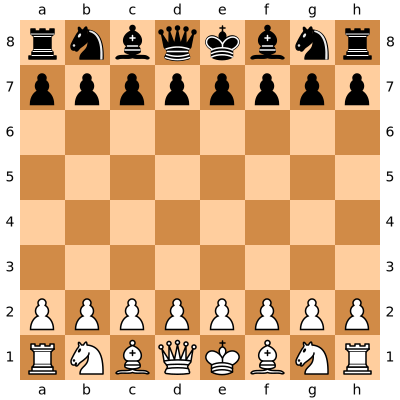

In [0]:
import chess
tree = MCTS()
board = BoardAi()
board

In [0]:
tree.do_rollout(board)

exploring 8 childrens from this position: 6K1/1k6/8/8/8/8/8/8 b - - 1539 1007
exploring 5 childrens from this position: 6K1/8/k7/8/8/8/8/8 w - - 1540 1008
exploring 5 childrens from this position: 7K/8/k7/8/8/8/8/8 b - - 1541 1008
exploring 3 childrens from this position: 7K/8/1k6/8/8/8/8/8 w - - 1542 1009
exploring 8 childrens from this position: 6K1/8/1k6/8/8/8/8/8 b - - 1543 1009
exploring 5 childrens from this position: 6K1/1k6/8/8/8/8/8/8 w - - 1544 1010
exploring 8 childrens from this position: 5K2/1k6/8/8/8/8/8/8 b - - 1545 1010
exploring 5 childrens from this position: 1k3K2/8/8/8/8/8/8/8 w - - 1546 1011
exploring 5 childrens from this position: 1k4K1/8/8/8/8/8/8/8 b - - 1547 1011
exploring 5 childrens from this position: 6K1/2k5/8/8/8/8/8/8 w - - 1548 1012
exploring 8 childrens from this position: 8/2k2K2/8/8/8/8/8/8 b - - 1549 1012
exploring 8 childrens from this position: 2k5/5K2/8/8/8/8/8/8 w - - 1550 1013
exploring 5 childrens from this position: 2k3K1/8/8/8/8/8/8/8 b - - 

KeyboardInterrupt: ignored

## Notre arbre marche mais ne s'arrate jamais!!

On. peut ajouter des conditions dans `is_terminal` et s'arreter pour une certaine profondeur d'arbre, et considerer qu'il y a un match nul dans ce cas la (meme une reward negative, car cela veut dire que on est loin d'avoir une bonne IA si on met 2000 coups d'echecs a gagner une partie... (regle des 50 coups sans prise de piont equivaut a un null, il faudrait peut etre l'utiliser)